# Portfolio Workflow

## Use the last week to determine current portfolio mix

In [1]:
from platform import python_version
import configparser
import logging.config
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import portfolio_optimizer
from portfolio_optimizer import OptimalHoldings
import trading_factors_yahoo as alpha_factors
import utils as utils

logging.config.fileConfig('./config/logging.ini')
logger = logging.getLogger('IRAHoldingsAdjustement')
logger.info(f'Python version: {python_version()}')
logger.info(f'Pandas version: {pd.__version__}')

config = configparser.ConfigParser()
config.read('./config/config.ini')
default_config = config['IRA']

# Which account are we interested in
masked_account_number = default_config['masked_account_number']
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = '../data/price_histories_yahoo.csv'

2022-11-14 08:49:05,625|IRAHoldingsAdjustement|INFO|Python version: 3.8.8
2022-11-14 08:49:05,628|IRAHoldingsAdjustement|INFO|Pandas version: 1.2.4


In [2]:
price_histories_file_name = default_config["DataDirectory"] + '/' + default_config["PriceHistoriesFileName"]
logger.info(f'PRICE_HISTORIES_FILE|{price_histories_file_name}...')
price_histories = pd.read_csv(price_histories_file_name, header=[0, 1], index_col=[0], parse_dates=True, low_memory=False)
logger.info(f'PRICE_HISTORIES|{price_histories.index.min()}|{price_histories.index.max()}')
returns = alpha_factors.FactorReturns(price_histories).factor_data

ai_alpha_factors_file_name = default_config['DataDirectory'] + '/' + default_config['AIAlphaFileName']
logger.info(f'AI_ALPHA_FACTORS_FILE|{ai_alpha_factors_file_name}')

beta_factors_file_name = default_config["DataDirectory"] + '/' + default_config["BetaFactorsFileName"]
logger.info(f'BETA_FACTORS_FILE|{beta_factors_file_name}')

alpha_vectors = pd.read_csv(ai_alpha_factors_file_name, parse_dates=['Date']).set_index(['Date']).sort_index()
logger.info(f'ALPHA_STOCKS|{len(alpha_vectors.columns)}')

2022-11-14 08:49:05,653|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES_FILE|./data/price_histories_yahoo.csv...
2022-11-14 08:49:06,889|IRAHoldingsAdjustement|INFO|PRICE_HISTORIES|2017-11-13 00:00:00|2022-11-11 00:00:00
2022-11-14 08:49:06,916|numexpr.utils|INFO|NumExpr defaulting to 4 threads.
2022-11-14 08:49:06,968|IRAHoldingsAdjustement|INFO|AI_ALPHA_FACTORS_FILE|./data/alpha_vectors.csv
2022-11-14 08:49:06,970|IRAHoldingsAdjustement|INFO|BETA_FACTORS_FILE|./data/daily_beta.pickle
2022-11-14 08:49:07,180|IRAHoldingsAdjustement|INFO|ALPHA_STOCKS|501


In [3]:
risk_cap = float(default_config['risk_cap'])
weights_max = float(default_config['weights_max'])
weights_min = float(default_config['weights_min'])
logger.info(f'OPTIMIZATION|risk_cap|{risk_cap}')
logger.info(f'OPTIMIZATION|weights_max|{weights_max}')
logger.info(f'OPTIMIZATION|weights_min|{weights_min}')

2022-11-14 08:49:07,191|IRAHoldingsAdjustement|INFO|OPTIMIZATION|risk_cap|0.08
2022-11-14 08:49:07,192|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_max|0.15
2022-11-14 08:49:07,198|IRAHoldingsAdjustement|INFO|OPTIMIZATION|weights_min|0.0


In [4]:
reduced_stocks = utils.reduce_universe_by_sentiment(alpha_vectors.columns)

Tickers:   0%|          | 0/501 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/501 [00:00<?, ?News Table Items/s]

In [5]:
# Error check to make sure we didn't reduce by too much

pct_red = len(reduced_stocks) / len(alpha_vectors.columns)
logger.info(f'SENTIMENT_REDUCTION|{pct_red:0.2f}|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
if pct_red < 0.50:
    logger.error(f'SENTIMENT_REDUCTION|OVER_REDUCED|{len(alpha_vectors.columns)}->{len(reduced_stocks)}')
    raise SystemExit

2022-11-14 08:52:37,575|IRAHoldingsAdjustement|INFO|SENTIMENT_REDUCTION|0.87|501->434


In [6]:
final_alhpa_vectors = alpha_vectors[reduced_stocks]
logger.info(f'FINAL_ALPHA_STOCKS|{len(final_alhpa_vectors.columns)}')
opt_date = final_alhpa_vectors.index[-1]
start_of_returns = opt_date - pd.offsets.DateOffset(years=1)
final_beta_returns = returns[reduced_stocks].loc[start_of_returns:opt_date]
risk_model = alpha_factors.RiskModelPCA(final_beta_returns, 1, 20)
logger.info(f'OPT_DATE|{opt_date}')
alpha_vector = pd.DataFrame(final_alhpa_vectors.loc[opt_date])
optimal_weights = OptimalHoldings(risk_cap=risk_cap,weights_max=weights_max, weights_min=weights_min).find(alpha_vector, risk_model.factor_betas_, risk_model.factor_cov_matrix_, risk_model.idiosyncratic_var_vector_)

2022-11-14 08:52:37,611|IRAHoldingsAdjustement|INFO|FINAL_ALPHA_STOCKS|434
2022-11-14 08:52:37,671|IRAHoldingsAdjustement|INFO|OPT_DATE|2022-11-11 00:00:00


2022-11-14 08:52:51,491|IRAHoldingsAdjustement|INFO|AJD_PORT_VARIANCE|0.01217903


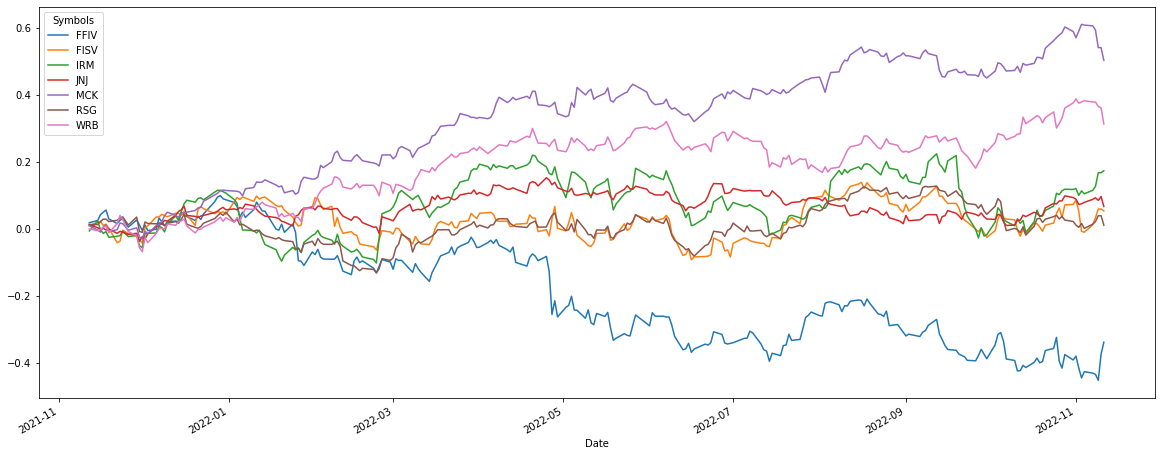

In [7]:
long_weights = optimal_weights[(100 * optimal_weights['optimalWeights']).round() > 5.0]
returns[-252:][long_weights.index.to_list()].cumsum().plot(figsize=(20,8))
logger.info(f'AJD_PORT_VARIANCE|{risk_model.compute_portfolio_variance(optimal_weights):.8f}')

In [8]:
for index, row in long_weights.iterrows():
    logger.info(f'STOCK|{index:20}|HOLDING|{row.optimalWeights:2f}')

2022-11-14 08:52:51,773|IRAHoldingsAdjustement|INFO|STOCK|FFIV                |HOLDING|0.150000
2022-11-14 08:52:51,775|IRAHoldingsAdjustement|INFO|STOCK|FISV                |HOLDING|0.150000
2022-11-14 08:52:51,776|IRAHoldingsAdjustement|INFO|STOCK|IRM                 |HOLDING|0.150000
2022-11-14 08:52:51,777|IRAHoldingsAdjustement|INFO|STOCK|JNJ                 |HOLDING|0.150000
2022-11-14 08:52:51,777|IRAHoldingsAdjustement|INFO|STOCK|MCK                 |HOLDING|0.100000
2022-11-14 08:52:51,779|IRAHoldingsAdjustement|INFO|STOCK|RSG                 |HOLDING|0.150000
2022-11-14 08:52:51,780|IRAHoldingsAdjustement|INFO|STOCK|WRB                 |HOLDING|0.150000


In [9]:
import ameritrade_functions as amc
import utils

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
display(td_ameritrade.get_fundamental(list(long_weights.index.to_list())))

2022-11-14 08:52:51,890|WDM|INFO|



====== WebDriver manager ======


2022-11-14 08:52:51,891|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 08:52:51,917|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 08:52:51,919|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 08:52:52,010|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,58155Q103,MCK,McKesson Corporation Common Stock,NYSE,EQUITY,401.78,215.2700,2.160,0.61,2022-11-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.5400,2023-01-03 00:00:00.000,0.63425,1433510.0,1433508.0,21392030.0
1,46284V101,IRM,Iron Mountain Incorporated (Delaware)Common St...,NYSE,EQUITY,58.61,41.6700,2.474,4.68,2022-12-14 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.6185,2023-01-05 00:00:00.000,0.87396,1484760.0,1484757.0,34529950.0
2,337738108,FISV,"Fiserv, Inc. - Common Stock",NASDAQ,EQUITY,110.99,87.0300,0.000,0.00,,...,51.86217,0.0,0.0,0.0,0.0000,,0.87926,5247570.0,5247571.0,89812410.0
3,084423102,WRB,W.R. Berkley Corporation Common Stock,NYSE,EQUITY,76.06,50.4400,0.400,0.57,2022-09-23 00:00:00.000,...,6.27220,0.0,0.0,0.0,0.1000,2022-10-03 00:00:00.000,0.62731,1410580.0,1410582.0,26096100.0
4,478160104,JNJ,Johnson & Johnson Common Stock,NYSE,EQUITY,186.69,155.7200,4.520,2.67,2022-11-21 00:00:00.000,...,1.59249,0.0,0.0,0.0,1.1300,2022-12-06 00:00:00.000,0.56364,6866600.0,6866603.0,152987270.0
5,760759100,RSG,"Republic Services, Inc. Common Stock",NYSE,EQUITY,149.17,113.5734,1.980,1.51,2022-12-30 00:00:00.000,...,4.54913,0.0,0.0,0.0,0.4950,2023-01-13 00:00:00.000,0.66600,1515330.0,1515329.0,25110730.0
6,315616102,FFIV,"F5, Inc. - Common Stock",NASDAQ,EQUITY,249.00,133.6750,0.000,0.00,,...,15.99641,0.0,0.0,0.0,0.0000,,1.08697,561440.0,561442.0,11037650.0


Tickers:   0%|          | 0/7 [00:00<?, ?Finvis Postings/s]

News Tables:   0%|          | 0/7 [00:00<?, ?News Table Items/s]

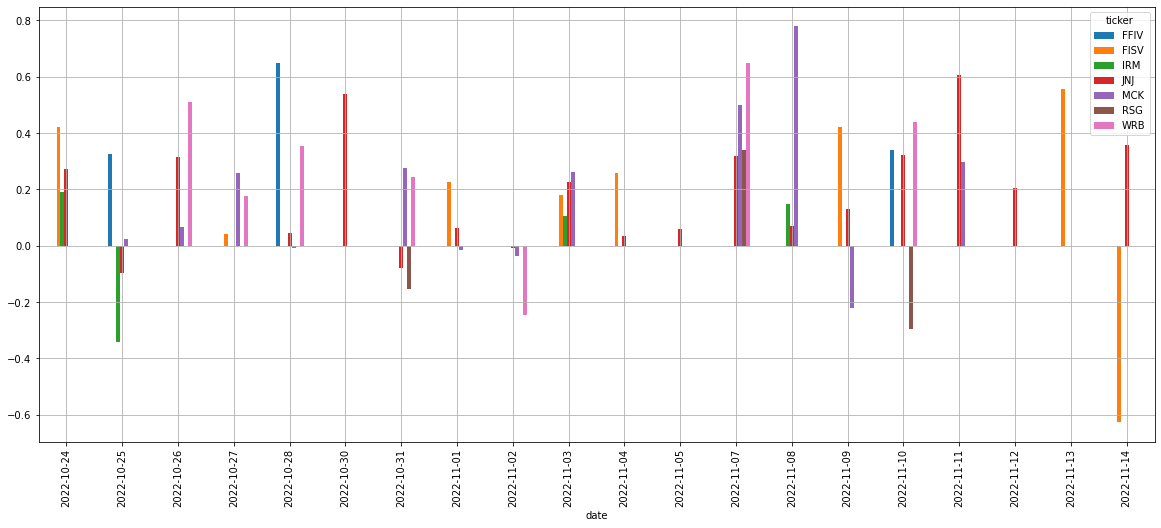

In [10]:
parsed_and_scored_news = utils.get_finvis_stock_sentiment(long_weights.index.to_list()).sort_values(by='date')
# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()
# Unstack the column ticker
mean_scores = mean_scores.unstack()
# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()
# Plot a bar chart with pandas
mean_scores[-20:].plot(kind = 'bar')
plt.grid()

## First lets see which stocks we already own for a specific account

I only want to work with Equity investments. This is kind of confusing, but at the account level assets that can be traded are call "EQUITY". When you get quotes for each asset, the same asset can be something like "ETF".

I also use Ameritrade's portfolio planner tool to create an asset mix based off of their reccomendations. I don't want these stocks (or in my case mutual funds and ETFs) to be part of this analysis. So I'll remove them here.

## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

## Authentication Tokens

To get data from Ameritrade you will need to obtains a short time use token (there is a re-use token, but I have not coded it yet.) You only need to do this if you
are going to use an existing Ameritrade account to define an initial set of stocks to analyze.

To obtain a token, you will need to have a Chrome driver located somewhere on your system. This will allow the module to use your credentials to obtain an authentication token.

For security reasons, I sugges using environment variables to store your credential information. If you store them in property files, or just code them into your notebook, you risk sharing the information with others if you use GitHub or some other SCCS. This also makes it easier to have them availabe from project to project in your development environment

<span style="color:blue">Note: *Account numbers are masked for security purposes.*</span>

In [11]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()

if len(td_ameritrade.authorization) == 0:
    logger.error(f'Error: No authorization data: {td_ameritrade.authorization}')
    raise Exeption
else:
    logger.info('You have authorization')

2022-11-14 08:53:38,915|WDM|INFO|



====== WebDriver manager ======


2022-11-14 08:53:38,921|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 08:53:38,956|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 08:53:38,957|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 08:53:39,017|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
2022-11-14 08:54:18,085|IRAHoldingsAdjustement|INFO|You have authorization


In [12]:
logger.info(f'TRADE_DATE|{datetime.today()}')

# Specific Portfolio Account
equity_investments_df = td_ameritrade.get_account_portfolio_data(masked_account_number, investment_type='EQUITY')
logger.info('Full Equity Portfolio:')
display(equity_investments_df)

2022-11-14 08:54:18,107|IRAHoldingsAdjustement|INFO|TRADE_DATE|2022-11-14 08:54:18.107198
2022-11-14 08:54:20,451|IRAHoldingsAdjustement|INFO|Full Equity Portfolio:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 SCHF              0.0      35.56279             0.0   
         VTIP              0.0      52.14316             0.0   
         VGK               0.0      59.10313             0.0   
         ULTA              0.0     415.11571             0.0   
         FNCL              0.0      40.44691             0.0   
         UNP               0.0     196.18750             0.0   
         USB               0.0      43.07000             0.0   
         FSTA              0.0      42.61006             0.0   
         EA                0.0     131.81312             0.0   
         SCHM              0.0      77.86802             0.0   
         VWO               0.0      50.42377             0.0   
         VBR               0.0     169.07886             0.0   
         FGPHF             0.0       0.12293             0.0   
         IVZ               0.0      15.81500             0.0   
         WKHS              0.0      12.43990             0.0   
         O                 0.0      63.13000             0.0   
         MPWR              0.0     347.41444             0.0   
         EEENF             0.0       0.04960             0.0   
         VOO               0.0     370.43264             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 SCHF                 0.00000                            0.00   
         VTIP                -0.71973                           -0.02   
         VGK                -13.29225                           -0.67   
         ULTA                -1.96000                           -0.07   
         FNCL                 0.00000                            0.00   
         UNP                -16.00000                           -0.46   
         USB                  0.00000                            0.00   
         FSTA                 0.00000                            0.00   
         EA                  -3.68000                           -0.18   
         SCHM                 0.00000                            0.00   
         VWO                  0.00000                            0.00   
         VBR                  0.00000                            0.00   
         FGPHF                0.00000                            0.00   
         IVZ                  0.00000                            0.00   
         WKHS               -10.00000                           -0.36   
         O                   -1.56000                           -0.05   
         MPWR                 0.00000                            0.00   
         EEENF                0.00000                            0.00   
         VOO               -153.55515                           -0.29   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 SCHF          60.707               60.707                   0.0   
         VTIP          71.973               71.973                   0.0   
         VGK           35.925               35.925                   0.0   
         ULTA           7.000                7.000                   0.0   
         FNCL          13.224               13.224                   0.0   
         UNP           16.000               16.000                   0.0   
         USB           76.000               76.000                   0.0   
         FSTA           5.088                5.088                   0.0   
         EA            16.000               16.000                   0.0   
         SCHM          20.291               20.291                   0.0   
         VWO           15.362               15.362                   0.0   
         VBR            3.094                3.094                   0.0   
         FGPHF     100000.000           100000.000                   0.0  

In [13]:
long_term_stocks = default_config['long_term_stocks'].split()
equity_stock_symbols = td_ameritrade.get_investment_symbols(masked_account_number, 'EQUITY')

# Filter out non Equity investments
current_stocks = td_ameritrade.get_quotes(equity_stock_symbols).query('assetType == "EQUITY"').index.tolist()
stocks_to_sell = equity_investments_df[equity_investments_df.index.get_level_values('symbol').isin(current_stocks)]
stocks_to_sell = stocks_to_sell[~stocks_to_sell.index.get_level_values('symbol').isin(long_term_stocks)]
logger.info(f'Stocks to sell:')
display(stocks_to_sell)

2022-11-14 08:54:20,773|IRAHoldingsAdjustement|INFO|Stocks to sell:


shortQuantity  averagePrice  currentDayCost  \
account  symbol                                                
#---5311 ULTA              0.0     415.11571             0.0   
         UNP               0.0     196.18750             0.0   
         USB               0.0      43.07000             0.0   
         EA                0.0     131.81312             0.0   
         IVZ               0.0      15.81500             0.0   
         O                 0.0      63.13000             0.0   
         MPWR              0.0     347.41444             0.0   

                 currentDayProfitLoss  currentDayProfitLossPercentage  \
account  symbol                                                         
#---5311 ULTA                   -1.96                           -0.07   
         UNP                   -16.00                           -0.46   
         USB                     0.00                            0.00   
         EA                     -3.68                           -0.18   
         IVZ                     0.00                            0.00   
         O                      -1.56                           -0.05   
         MPWR                    0.00                            0.00   

                 longQuantity  settledLongQuantity  settledShortQuantity  \
account  symbol                                                            
#---5311 ULTA             7.0                  7.0                   0.0   
         UNP             16.0                 16.0                   0.0   
         USB             76.0                 76.0                   0.0   
         EA              16.0                 16.0                   0.0   
         IVZ            210.0                210.0                   0.0   
         O               52.0                 52.0                   0.0   
         MPWR             9.0                  9.0                   0.0   

                 marketValue  maintenanceRequirement  \
account  symbol                                        
#---5311 ULTA        3009.93                 3009.93   
         UNP         3464.00                 3464.00   
         USB         3413.92                 3413.92   
         EA          2096.00                 2096.00   
         IVZ         4151.70                 4151.70   
         O           3377.40                 3377.40   
         MPWR        3540.33                 3540.33   

                 previousSessionLongQuantity assetType      cusip description  \
account  symbol                                                                 
#---5311 ULTA                            7.0    EQUITY  90384S303           0   
         UNP                            16.0    EQUITY  907818108           0   
         USB                            76.0    EQUITY  902973304           0   
         EA                             16.0    EQUITY  285512109           0   
         IVZ                           210.0    EQUITY  G491BT108           0   
         O                              52.0    EQUITY  756109104           0   
         MPWR                            9.0    EQUITY  609839105           0   

                type  
account  symbol       
#---5311 ULTA      0  
         UNP       0  
         USB       0  
         EA        0  
         IVZ       0  
         O         0  
         MPWR      0

### Submit and montior sell orders

In [15]:
import importlib
importlib.reload(amc)

<module 'ameritrade_functions' from 'c:\\users\\hp-z440\\anaconda projects\\svi-trading-tools\\tools\\ameritrade_functions.py'>

In [16]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)
sell_result = td_ameritrade.place_bulk_sell_orders(account_number, stocks_to_sell)

2022-11-14 09:06:23,479|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:06:23,481|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:06:23,536|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:06:23,538|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:06:23,624|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing SELL order on #---5311 for 7.0 shares of ULTA...
Placed SELL order on #---5311 for 7.0 shares of ULTA
Placing SELL order on #---5311 for 16.0 shares of UNP...
Placed SELL order on #---5311 for 16.0 shares of UNP
Placing SELL order on #---5311 for 76.0 shares of USB...
Placed SELL order on #---5311 for 76.0 shares of USB
Placing SELL order on #---5311 for 16.0 shares of EA...
Placed SELL order on #---5311 for 16.0 shares of EA
Placing SELL order on #---5311 for 210.0 shares of IVZ...
Placed SELL order on #---5311 for 210.0 shares of IVZ
Placing SELL order on #---5311 for 52.0 shares of O...
Placed SELL order on #---5311 for 52.0 shares of O
Placing SELL order on #---5311 for 9.0 shares of MPWR...
Placed SELL order on #---5311 for 9.0 shares of MPWR


In [ ]:
while True:
    td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
    td_ameritrade.authenticate()
    account_portfolio_df = utils.get_account_portfolio_data(td_ameritrade.parse_portfolios_list(), masked_account_number)
    equity_investments_df = utils.get_investments_by_type(account_portfolio_df, investment_type='EQUITY')
    stocks_with_sell_orders = equity_investments_df[equity_investments_df['symbol'].isin(stocks_to_sell.symbol.values)]
    if len(stocks_with_sell_orders[stocks_with_sell_orders.longQuantity >= 1]) == 0:
        break
    logger.info(f'\rStocks to sell|{stocks_with_sell_orders.symbol.values}')
    time.sleep(60)
    
logger.info(f'\rAll stocks sold|{stocks_to_sell.symbol.values}')


In [22]:
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
account_balances = td_ameritrade.parse_accounts().loc[masked_account_number]
display(account_balances)
print(account_balances.currentBalances_cashBalance)
print(account_balances.currentBalances_moneyMarketFund)
available_cash = account_balances.currentBalances_cashBalance + account_balances.currentBalances_moneyMarketFund
logger.info(f'INVESTMENT_AMT|{available_cash}')

2022-11-14 09:43:10,349|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:43:10,351|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:43:10,406|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:43:10,408|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:43:10,490|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


initialBalances_cashBalance            0.000000
initialBalances_totalCash              0.000000
initialBalances_equity             92938.660000
initialBalances_moneyMarketFund     2662.990000
currentBalances_cashBalance        23023.640000
currentBalances_equity             92508.880000
currentBalances_moneyMarketFund     2662.990000
current_return                        -0.004635
Name: #---5311, dtype: float64

23023.64
2662.99
2022-11-14 09:43:52,043|IRAHoldingsAdjustement|INFO|INVESTMENT_AMT|25686.629999999997


In [23]:
print(f'Available cash  : {available_cash}')
investment_base = 1000
investment_amount = math.floor(available_cash / investment_base) * investment_base
print(f'Amount to invest: {investment_amount}')

Available cash  : 25686.629999999997
Amount to invest: 25000


In [19]:
long_weights

,optimalWeights
FFIV,0.15
FISV,0.15
IRM,0.15
JNJ,0.15
MCK,0.10
RSG,0.15
WRB,0.15


In [24]:
print(datetime.today())
print(f'Initial investment amount: {investment_amount}')
nearest_base = 5
min_shares = 5
long_quotes = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
long_shares = long_quotes['regularMarketLastPrice'].to_frame()
long_shares['optimalWeights'] = long_weights['optimalWeights']
long_shares['invest_amount'] = (long_shares['optimalWeights'] * investment_amount).round(0)
long_shares['shares'] = (long_shares['invest_amount'] / long_shares['regularMarketLastPrice']).astype(int)
display(long_shares)

# Remove symbols that are less than min and re-compute

final_long_shares = long_shares.query('shares >= @min_shares').copy()
final_long_shares['optimalWeights'] = final_long_shares['optimalWeights'] / final_long_shares['optimalWeights'].sum(axis=0)
final_long_shares['invest_amount'] = (final_long_shares['optimalWeights'] * investment_amount).round(0)
final_long_shares['shares'] = (final_long_shares['invest_amount'] / final_long_shares['regularMarketLastPrice']).astype(int)
final_long_shares['cost'] = final_long_shares['shares'] * final_long_shares['regularMarketLastPrice']
display(final_long_shares)
print(f'Total cost: {final_long_shares.cost.sum()}')


2022-11-14 09:44:14.812729
Initial investment amount: 25000


,regularMarketLastPrice,optimalWeights,invest_amount,shares
FFIV,149.91,0.15,3750.0,25
FISV,100.47,0.15,3750.0,37
IRM,52.87,0.15,3750.0,70
JNJ,169.25,0.15,3750.0,22
MCK,356.21,0.10,2500.0,7
RSG,131.06,0.15,3750.0,28
WRB,69.77,0.15,3750.0,53


,regularMarketLastPrice,optimalWeights,invest_amount,shares,cost
FFIV,149.91,0.15,3750.0,25,3747.75
FISV,100.47,0.15,3750.0,37,3717.39
IRM,52.87,0.15,3750.0,70,3700.90
JNJ,169.25,0.15,3750.0,22,3723.50
MCK,356.21,0.10,2500.0,7,2493.47
RSG,131.06,0.15,3750.0,28,3669.68
WRB,69.77,0.15,3750.0,53,3697.81


Total cost: 24750.5


### Place buy orders

In [25]:
amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_quotes(long_weights.index.to_list())
td_ameritrade.get_fundamental(list(final_long_shares.index))

,cusip,symbol,description,exchange,assetType,high52,low52,dividendAmount,dividendYield,dividendDate,...,bookValuePerShare,shortIntToFloat,shortIntDayToCover,divGrowthRate3Year,dividendPayAmount,dividendPayDate,beta,vol1DayAvg,vol10DayAvg,vol3MonthAvg
0,58155Q103,MCK,McKesson Corporation Common Stock,NYSE,EQUITY,401.78,215.2700,2.160,0.61,2022-11-30 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.5400,2023-01-03 00:00:00.000,0.63425,1433510.0,1433508.0,21392030.0
1,46284V101,IRM,Iron Mountain Incorporated (Delaware)Common St...,NYSE,EQUITY,58.61,41.6700,2.474,4.68,2022-12-14 00:00:00.000,...,0.00000,0.0,0.0,0.0,0.6185,2023-01-05 00:00:00.000,0.87396,1484760.0,1484757.0,34529950.0
2,337738108,FISV,"Fiserv, Inc. - Common Stock",NASDAQ,EQUITY,110.99,87.0300,0.000,0.00,,...,51.86217,0.0,0.0,0.0,0.0000,,0.87926,5247570.0,5247571.0,89812410.0
3,084423102,WRB,W.R. Berkley Corporation Common Stock,NYSE,EQUITY,76.06,50.4400,0.400,0.57,2022-09-23 00:00:00.000,...,6.27220,0.0,0.0,0.0,0.1000,2022-10-03 00:00:00.000,0.62731,1410580.0,1410582.0,26096100.0
4,478160104,JNJ,Johnson & Johnson Common Stock,NYSE,EQUITY,186.69,155.7200,4.520,2.67,2022-11-21 00:00:00.000,...,1.59249,0.0,0.0,0.0,1.1300,2022-12-06 00:00:00.000,0.56364,6866600.0,6866603.0,152987270.0
5,760759100,RSG,"Republic Services, Inc. Common Stock",NYSE,EQUITY,149.17,113.5734,1.980,1.51,2022-12-30 00:00:00.000,...,4.54913,0.0,0.0,0.0,0.4950,2023-01-13 00:00:00.000,0.66600,1515330.0,1515329.0,25110730.0
6,315616102,FFIV,"F5, Inc. - Common Stock",NASDAQ,EQUITY,249.00,133.6750,0.000,0.00,,...,15.99641,0.0,0.0,0.0,0.0000,,1.08697,561440.0,561442.0,11037650.0


In [26]:
print(datetime.today())
td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_portfolios_list()
account_number = td_ameritrade.unmask_account(masked_account_number)

for index, row in final_long_shares.iterrows():
    fundamental = td_ameritrade.get_fundamental([index])
    print(f'Placing BUY order on {account_number} for {row.shares} shares of {index}:{fundamental.loc[0].assetType}...')
    result = td_ameritrade.place_order(account_number, index, fundamental.loc[0].assetType, row.shares, 'BUY')

2022-11-14 09:44:34.914217
2022-11-14 09:44:34,915|WDM|INFO|



====== WebDriver manager ======


2022-11-14 09:44:34,917|WDM|INFO|====== WebDriver manager ======


Current google-chrome version is 107.0.5304


2022-11-14 09:44:34,962|WDM|INFO|Current google-chrome version is 107.0.5304


Get LATEST chromedriver version for 107.0.5304 google-chrome


2022-11-14 09:44:34,964|WDM|INFO|Get LATEST chromedriver version for 107.0.5304 google-chrome


Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache


2022-11-14 09:44:35,035|WDM|INFO|Driver [C:\Users\HP-Z440\.wdm\drivers\chromedriver\win32\107.0.5304.62\chromedriver.exe] found in cache
Placing BUY order on 495855311 for 25.0 shares of FFIV:EQUITY...
Placed BUY order on #---5311 for 25.0 shares of FFIV
Placing BUY order on 495855311 for 37.0 shares of FISV:EQUITY...
Placed BUY order on #---5311 for 37.0 shares of FISV
Placing BUY order on 495855311 for 70.0 shares of IRM:EQUITY...
Placed BUY order on #---5311 for 70.0 shares of IRM
Placing BUY order on 495855311 for 22.0 shares of JNJ:EQUITY...
Placed BUY order on #---5311 for 22.0 shares of JNJ
Placing BUY order on 495855311 for 7.0 shares of MCK:EQUITY...
Placed BUY order on #---5311 for 7.0 shares of MCK
Placing BUY order on 495855311 for 28.0 shares of RSG:EQUITY...
Placed BUY order on #---5311 for 28.0 shares of RSG
Placing BUY order on 495855311 for 53.0 shares of WRB:EQUITY...
Placed BUY order on #---5311 for 53.0 shares of WRB


In [ ]:
number_of_years = 5
portfolio_price_histories = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid').get_price_histories(list(long_shares.index), datetime.today().strftime('%Y-%m-%d'), num_periods=number_of_years)
portfolio_close = utils.get_close_values(portfolio_price_histories)
utils.compute_log_returns(portfolio_close)[-5:].cumsum().plot()

## import ameritrade_functions as amc

td_ameritrade = amc.AmeritradeRest('maiotradeuser', 'maiotradepw', 'maiotradeclientid')
td_ameritrade.authenticate()
td_ameritrade.parse_accounts().loc[masked_account_number]